# Fraud detection assignment
* Read fraud detection paper, it contains several example techniques and issues
* Determine whether you have sufficient background to complete this course, you should already be able to implement the  machine learning techniques mentioned in the paper
* Understand the example python code for performing kNN on the fraud data (make sure you also have scikitlearn installed in addition to Python 2.7)
* Explore and visualize the fraud data set
* Apply basic ML algorithms on the fraud data
* Reflect on the usability of your results in practice (white-box, fraud game)
* This is a part of the first lab assignment, there is no deliverable this week, more tasks follow in upcoming two weeks

## Step 1: explorer and visualize the fraud dataset


In [8]:
import datetime
import time
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
from sklearn import neighbors
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from operator import itemgetter
from itertools import groupby
import numpy as np
import pandas as pd

In [7]:
src = 'data_for_student_case.csv'
df = pd.read_csv(src)

In [9]:
df.head()

,txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,simple_journal,cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id
0,1,2015-11-09 14:26:51,MX,mccredit,530056.0,64800.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-01 23:03:11,MexicoAccount,email68370,ip111778,card184798
1,2,2015-11-09 14:27:38,MX,mccredit,547046.0,44900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 04:50:55,MexicoAccount,email101299,ip78749,card151595
2,3,2015-11-23 16:34:16,MX,mccredit,528843.0,149900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 14:30:28,MexicoAccount,email278604,ip70594,card242142
3,4,2015-11-23 16:34:51,MX,mccredit,547146.0,109900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-03 07:53:37,MexicoAccount,email47409,ip113648,card181744
4,5,2015-11-09 14:26:08,MX,visaclassic,477291.0,89900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-08 18:35:35,MexicoAccount,email205501,ip83553,card97271


### Data Cleaning
* Since "refused" transactions are ambiguous, we drop them here.
* Transform 'creationdate' to the data strucutre which pandas can read
* assign labels
* other cleaning

In [9]:
cleaned_df = df.copy()
cleaned_df = cleaned_df[df['simple_journal']!='Refused']

In [20]:
cleaned_df['date'] = pd.to_datetime(cleaned_df['creationdate'],format='%Y-%m-%d %H:%M:%S')
print cleaned_df.date[0].year
print cleaned_df.date[0].month
cleaned_df.date[0] > cleaned_df.date[10]

2015
7


False

In [21]:
# assign labels: 1 for fraud, 0 for normal
cleaned_df['label'] = cleaned_df['simple_journal'].apply(lambda x: x=='Chargeback')

In [22]:
# some cleaning for cvc response
cleaned_df['cvcresponsecode'] = cleaned_df['cvcresponsecode'].apply(lambda x: (x>2) * 3 + (x<=2)*x) 

## Visualization 

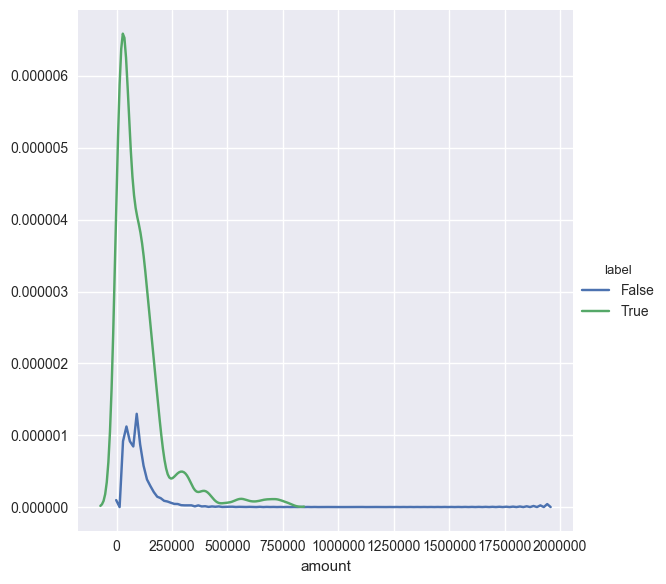

In [49]:
import seaborn as sns
sns.FacetGrid(cleaned_df, hue="label", size=6) \
   .map(sns.kdeplot, "amount") \
   .add_legend()

In [39]:
sns.pairplot(cleaned_df, palette="husl",vars=['bin','amount','issuercountrycode'] ,hue="label", size=3)

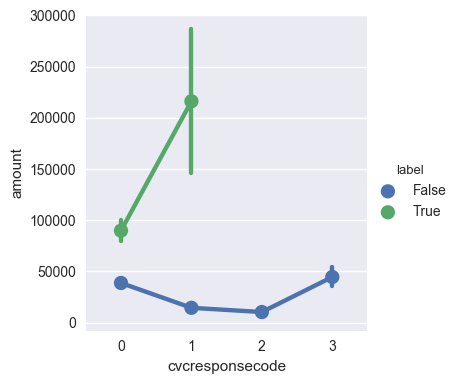

In [38]:
sns.factorplot(data=cleaned_df,x="cvcresponsecode", y="amount", hue="label")

In [40]:
fraud_df = cleaned_df[cleaned_df['label']==True]
safe_df =  cleaned_df[cleaned_df['label']==False]

## It's a very imbalenced dataset!!

In [48]:
print 'Number of fraud:',len(fraud_df)
print 'Number of safe trasactions:',len(safe_df)
print 'Percentage of fraud:',100.0*len(fraud_df)/len(cleaned_df),'%'

Number of fraud: 345
Number of safe trasactions: 236691
Percentage of fraud: 0.14554751177 %


- issuercountrycode: country where the card was issued
- txvariantcode: the card type that was used (subbrand of visa or master card)
- bin: card issuer identifier
- amount/currencycode: transaction amount in minor units (so 100 EUR = 100 euro cent)
- shoppercountrycode: IP address country
- shopperinteraction: Ecommerce if it was an online transaction, ContAuth if it was a (monthly) subscription
- simple_journal: Payment status. Authorised = “transaction approved and no fraud reported”, Refused = “transaction was declined, can be fraud, but can also be insufficient funds, etc”, Chargeback = “transaction was approved, but turned out to be fraud”
- bookingdate: only relevant for Chargebacks. Time stamp when the chargeback was reported. During simulation you may only use this knowledge after this date. So for example if on an email address a transaction ended in a chargeback, you can only block that email address after the booking date of the chargeback.
- cardverificationresponsesupplied: did the shopper provide his 3 digit CVC/CVV2 code?
- cvcresponsecode: Validation result of the CVC/CVV2 code: 0 = Unknown, 1=Match, 2=No Match, 3-6=Not checked
- creationdate: Date of transaction
- accountcode: merchant’s webshop
- mail_id: Email address
- ip_id: Ip address
- card_id: Card number